# Report
---

This report contains description of some basic experiments with conclusions and proposals for next steps. All experiments included into the repo passed success criteria. 
Main sections: 
   
 **1) Experiments overiew** - Description of methods used to train agent.  
 **2) Experiment metadata** - Introduction to experiments metadata and its basic usage.  
 **3) Evaluation of results** - Some detailed plots and measurements for each experiment.   
 **4) Next steps**  

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [6]:
from qrl_navigation.model import DuelingQNetwork
from qrl_navigation.replay_buffer import ReplayWeightedBuffer
from qrl_navigation.agent import WeightedAgent, Agent
from qrl_navigation.environment import BananaMazeEnv
from qrl_navigation.training import dqn_training
import torch
import pickle
import time

In [17]:
def get_avg_scores(scores, n_samples):
    cs = np.cumsum(scores)
    diff = cs[n_samples:] - cs[:-n_samples]
    avg = diff / n_samples
    return avg
    
def get_best_avg_score(scores, n_samples):
    avg = get_avg_scores(scores, n_samples)
    idxs = np.argsort(avg)[::-1][:3]
    avg_subset = avg[idxs]
    
    return idxs + n_samples, avg_subset

def get_occurance(scores, n_samples, value):
    avg = get_avg_scores(scores, n_samples)
    return np.where(avg >= value)[0][0] + n_samples


## Experiments overview

We have used training algorithm based on **double q-learing** [[1]](https://arxiv.org/abs/1509.06461) with deep neural network predicting for each state action-value distribution across all possible next actions. Details of algorithm itself are described in [Human-level control through Deep Reinforcement Learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) paper in apendix method section *Training algorithm for deep Q-networks* 

**Agents** 
  - **basic** - Feed forward neural net (input (state size)->hidden layer (64 neurons) -> hidden layer (64 neuron) -> output (action size)).
  - **dueling** - Dueling Q network with separated action and value part merged in last layer to one output [[2]](https://arxiv.org/pdf/1511.06581.pdf).  
  
  Params
    - state_size - dimension of each state
    - action_size - dimension of each action
    - fc_units  - list of unit counts in each layer of q-network
    - buffer_size (5000) - replay buffer size
    - batch_size (64) - size of sampled batches from replay buffer
    - lr (0.0005) - learning rate
    - gamma (0.99) - reward discount
    - tau (0.001) - soft update of target network parameters
    - eps (decay from 1 to 0.01) - for epsilon-greedy action selection
    - update_rate (4) - every update_rate step network params are updated

**Replay Buffers**
  - **non-weighted** - Basic replay buffer sampling uniformly examples to train.
  - **weighted** - Weighting with respect to error produced for samples, agent includes debias term [[3]](https://arxiv.org/abs/1511.05952).

## Experiment data

### Metadata insights
Each experiment in repo has it's own metadata file with details of experiemnt and of course separate pytorch weights of trained agent. Lets have a look at ```../experiments/dueling``` which contains results for dueling agent with basic non weighted replay buffer.

In [6]:
meta = pickle.load(open('../experiments/dueling/meta.pickle', 'rb'))

In [7]:
# repr string for agent initialization
meta['agent']

'Agent(state_size=37, action_size=4, fc_units=[64, 64], device="cuda", dueling=True)'

In [9]:
# result scores during training
meta['scores'][800:810]

[12.0, 13.0, 16.0, 22.0, 18.0, 12.0, 4.0, 10.0, 18.0, 21.0]

In [10]:
# path to agent nn weights 
meta['model_path']

'../experiments/dueling/model.pt'

### Evaluation of model

In [11]:
agent = eval(meta['agent'])

In [12]:
agent.load(meta['model_path'])

In [13]:
maze_env = BananaMazeEnv(train_mode=True)

DEBUG:unityagents:The true file name is Banana
DEBUG:unityagents:This is the launch string /home/adam/code/qrl_navigation/notebooks/../bin/unity_banana_maze/Banana.x86_64
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [14]:
state = maze_env.reset()
score = 0
for step in range(1000):
    action = agent.act(state, 0.01)
    next_state, reward, done = maze_env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if reward != 0:
        print(f'Score update: {score}')
    time.sleep(0.05)
    if done:
        break
print(f'Final score is {score}')

Score update: 1.0
Score update: 2.0
Score update: 3.0
Score update: 4.0
Score update: 5.0
Score update: 6.0
Score update: 7.0
Score update: 8.0
Score update: 9.0
Score update: 10.0
Score update: 11.0
Score update: 12.0
Score update: 13.0
Score update: 14.0
Score update: 15.0
Score update: 16.0
Score update: 17.0
Score update: 18.0
Score update: 19.0
Final score is 19.0


In [15]:
maze_env.close()

## Evaluation of results
Experiemts are not representative at all since we did just one for each setup. It mainly showcases open possibilities.  
Plots you will see represetns progress over binned scores during training. Each dot represetns gourp of scores in given bin with its variance.

### Loading of 4 major experiments

In [8]:
meta_dueling = pickle.load(open('../experiments/dueling/meta.pickle', 'rb'))
meta_dueling_w = pickle.load(open('../experiments/dueling_weighted/meta.pickle', 'rb'))
meta_basic = pickle.load(open('../experiments/basic/meta.pickle', 'rb'))
meta_basic_w = pickle.load(open('../experiments/basic_weighted/meta.pickle', 'rb'))


data_dueling = pd.DataFrame({'scores': meta_dueling['scores'], 'iterations': range(len(meta_dueling['scores']))})
data_basic = pd.DataFrame({'scores': meta_basic['scores'], 'iterations': range(len(meta_basic['scores']))})
data_dueling_w = pd.DataFrame({'scores': meta_dueling_w['scores'], 'iterations': range(len(meta_dueling_w['scores']))})
data_basic_w = pd.DataFrame({'scores': meta_basic_w['scores'], 'iterations': range(len(meta_basic_w['scores']))})

### Basic vs. Basic with weighted replay buffer
Weighted prioritized buffer should help improving results faster since it picks more problematic *sars* setups with higher probability.


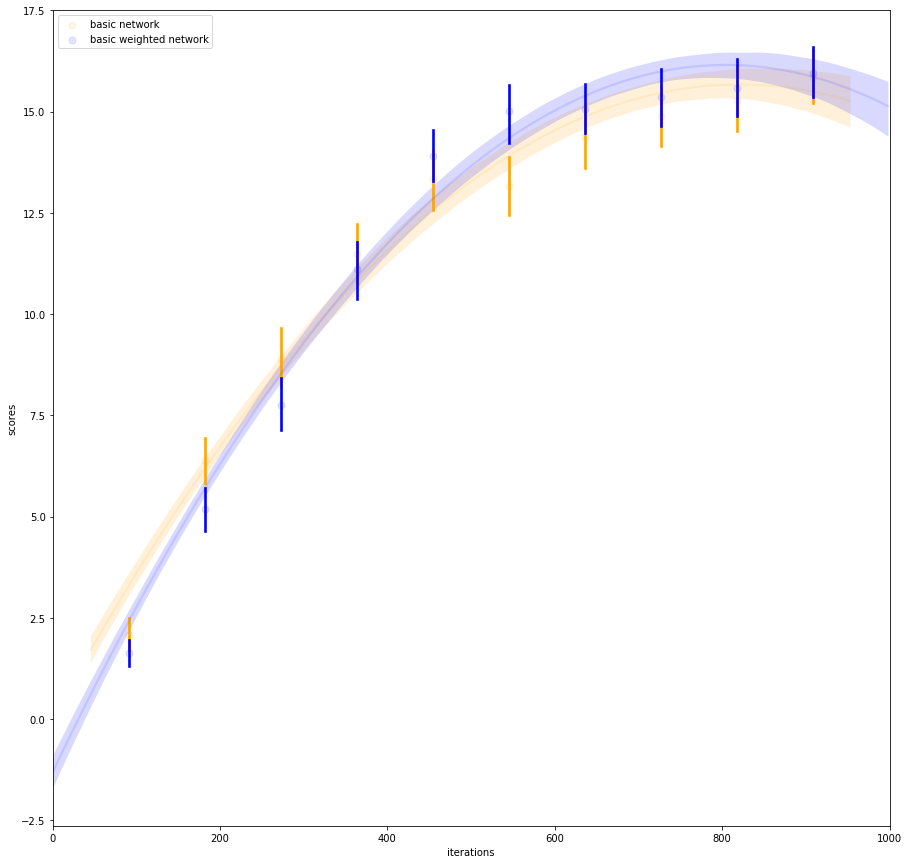

In [9]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
sns.regplot(x='iterations', y='scores', data=data_basic_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='blue', label='basic weighted network')
plt.xlim(0, 1000)
plt.legend()

In [10]:
print(f'Percentile scores, non-weighted vs. weighted:')
print(np.percentile(meta_basic['scores'], [5, 25, 50, 75, 95]))
print(np.percentile(meta_basic_w['scores'], [5, 25, 50, 75, 95]))

Percentile scores, non-weighted vs. weighted:
[  1.   7.  12.  16.  20.]
[  1.   7.  13.  16.  20.]


In [11]:
print(f'Mean score after 1000 runs, non-weighted vs. weighted: {np.mean((meta_basic["scores"]))} vs. {np.mean((meta_basic_w["scores"]))}')

Mean score after 1000 runs, non-weighted vs. weighted: 11.336 vs. 11.395


### Dueling vs. Dueling with weighted buffer

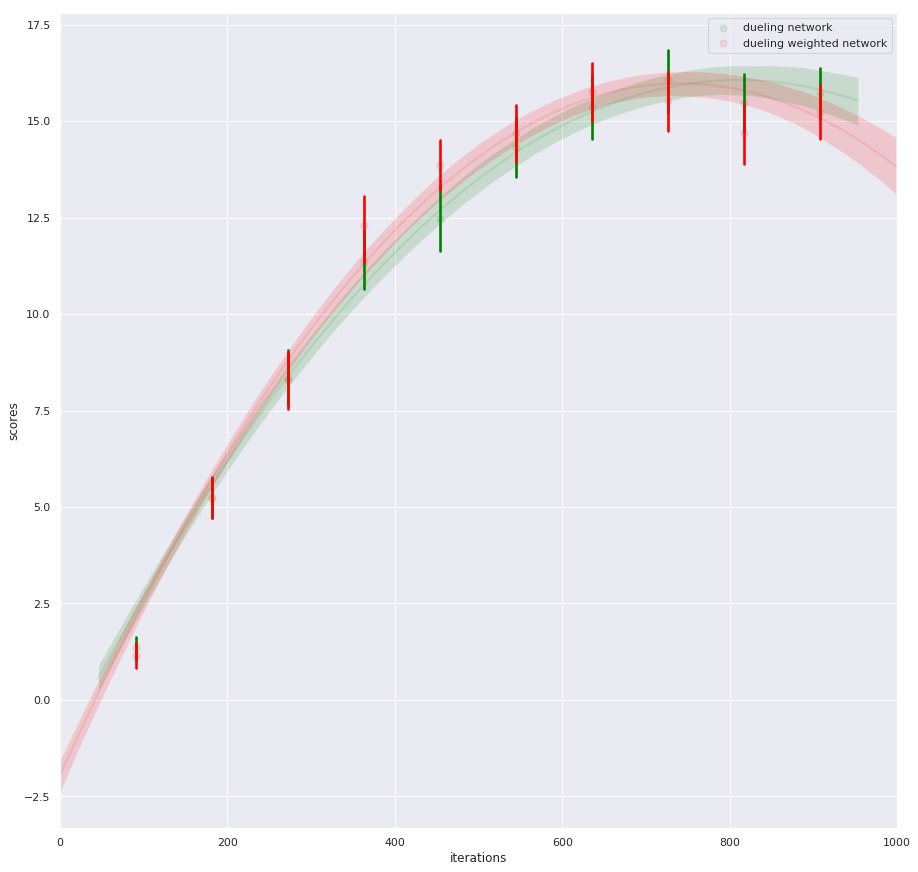

In [117]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_dueling, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='green', label='dueling network')
sns.regplot(x='iterations', y='scores', data=data_dueling_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='red', label='dueling weighted network')
plt.xlim(0, 1000)
plt.legend()

In [133]:
print(f'Percentile scores, non-weighted vs. weighted:')
print(np.percentile(meta_dueling['scores'], [5, 25, 50, 75, 95]))
print(np.percentile(meta_dueling_w['scores'], [5, 25, 50, 75, 95]))

Percentile scores, non-weighted vs. weighted:
[  0.   6.  12.  16.  21.]
[  0.   7.  12.  16.  20.]


In [135]:
print(f'Mean score after 1000 runs, non-weighted vs. weighted: {np.mean((meta_dueling["scores"]))} vs. {np.mean((meta_dueling_w["scores"]))}')

Mean score after 1000 runs, non-weighted vs. weighted: 11.29 vs. 11.349


### Dueling vs. Basic
Despite dueling network has more parameters and colder start, at the end it should get better results because of separating value and action parts with kind of residual trick which enables smooth propagation of gradients.

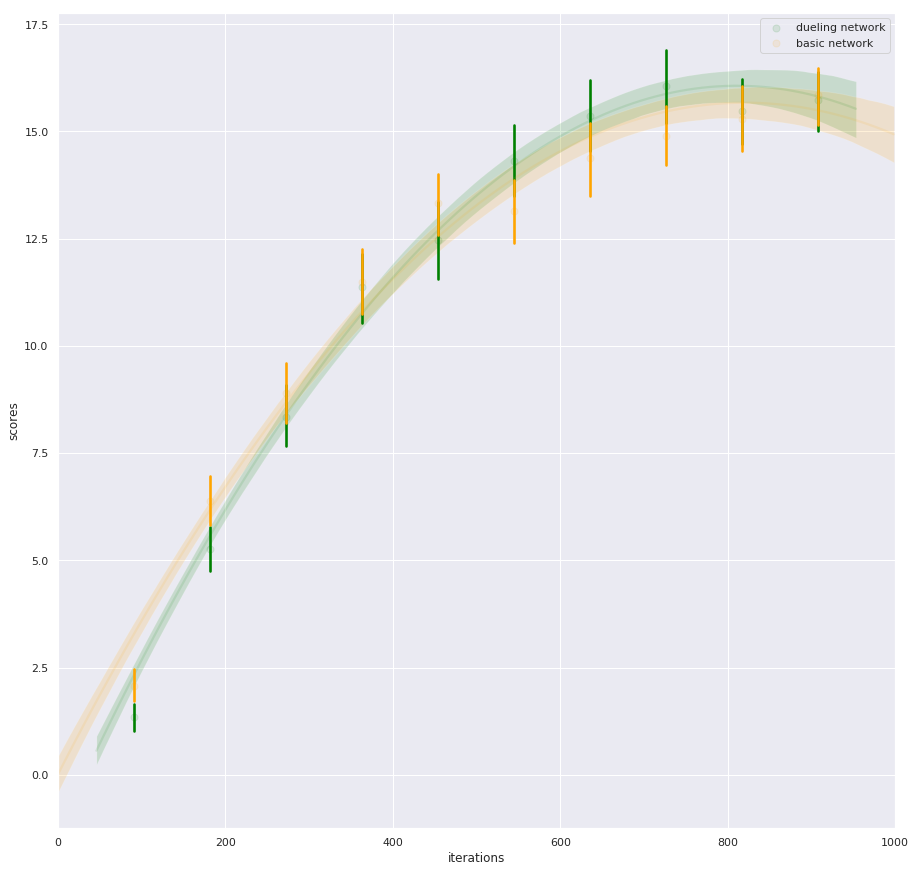

In [118]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_dueling, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='green', label='dueling network')
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
plt.xlim(0, 1000)
plt.legend()

In [136]:
print(f'Percentile scores, basic vs. dueling:')
print(np.percentile(meta_basic['scores'], [5, 25, 50, 75, 95]))
print(np.percentile(meta_dueling['scores'], [5, 25, 50, 75, 95]))

Percentile scores, basic vs. dueling:
[  1.   7.  12.  16.  20.]
[  0.   6.  12.  16.  21.]


In [137]:
print(f'Mean score after 1000 runs, basic vs. dueling: {np.mean((meta_basic["scores"]))} vs. {np.mean((meta_dueling["scores"]))}')

Mean score after 1000 runs, basic vs. dueling: 11.336 vs. 11.29


### Overall comparison

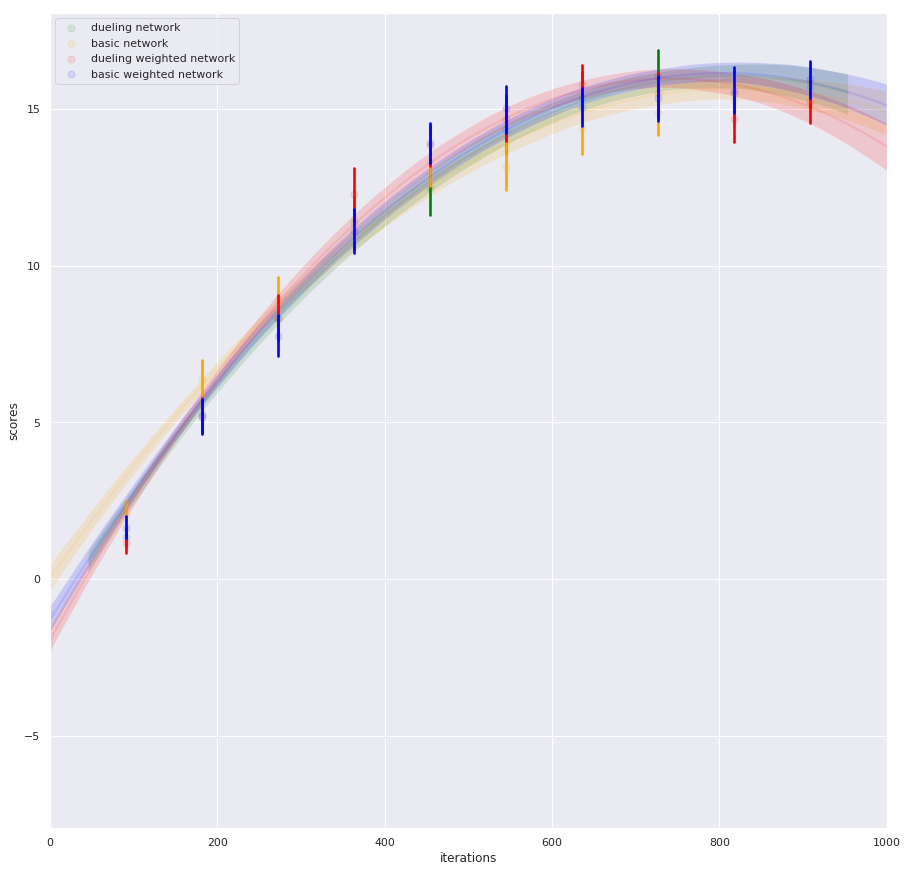

In [101]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_dueling, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='green', label='dueling network')
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
sns.regplot(x='iterations', y='scores', data=data_dueling_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='red', label='dueling weighted network')
sns.regplot(x='iterations', y='scores', data=data_basic_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='blue', label='basic weighted network')
plt.xlim(0, 1000)
plt.legend()

### Single model analysis

#### Basic

In [12]:
# gives iteration with top scores for given experiment and avg scores (here counted for 30 consecutive samples)
get_best_avg_score(meta_basic['scores'], 30)

(array([940, 941, 939]), array([ 17.16666667,  17.06666667,  17.03333333]))

In [18]:
# iteration when we for the first time reached avg score for 100 consecutive scores >=13
get_occurance(meta_basic['scores'], n_samples=100, value=13)

476

Text(0.5,0.98,'Plot of raw scores got from each single iteration')

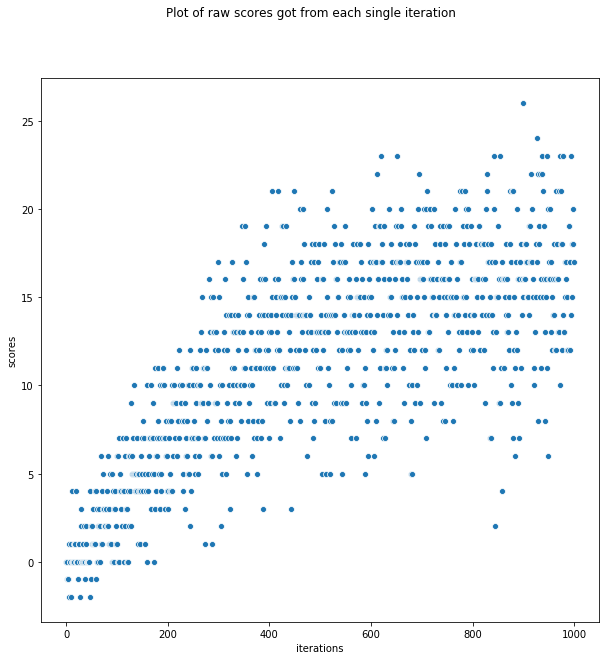

In [24]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(x='iterations', y='scores', data=data_basic, ax=ax)
plt.suptitle('Plot of raw scores got from each single iteration')

#### Dueling

In [22]:
# gives iteration with top scores for given experiment and avg scores (here counted for 30 consecutive samples)
get_best_avg_score(meta_dueling['scores'], 30)

(array([918, 919, 921]), array([ 17.7       ,  17.7       ,  17.53333333]))

In [19]:
# iteration when we for the first time reached avg score for 100 consecutive scores >=13
get_occurance(meta_dueling['scores'], n_samples=100, value=13)

540

Text(0.5,0.98,'Plot of raw scores got from each single iteration')

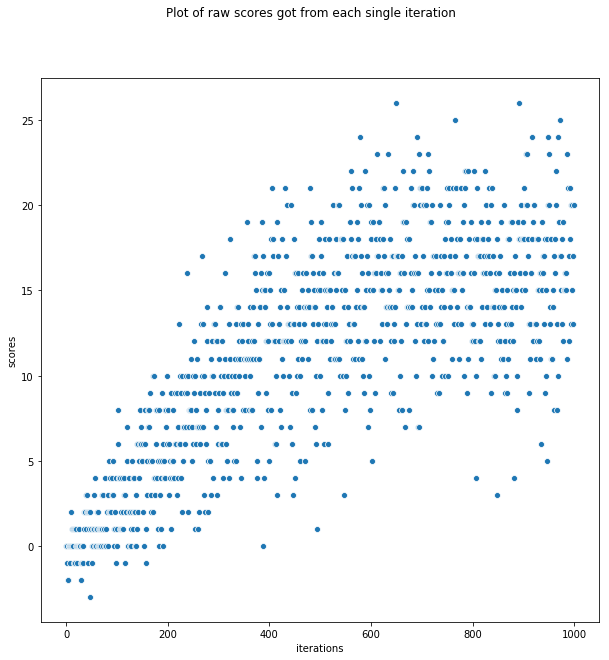

In [23]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(x='iterations', y='scores', data=data_dueling, ax=ax)
plt.suptitle('Plot of raw scores got from each single iteration')

#### Basic Weighted

In [23]:
# gives iteration with top scores for given experiment and avg scores (here counted for 30 consecutive samples)
get_best_avg_score(meta_basic_w['scores'], 30)

(array([989, 996, 988]), array([ 17.13333333,  17.13333333,  17.1       ]))

In [20]:
# iteration when we for the first time reached avg score for 100 consecutive scores >=13
get_occurance(meta_basic_w['scores'], n_samples=100, value=13)

466

Text(0.5,0.98,'Plot of raw scores got from each single iteration')

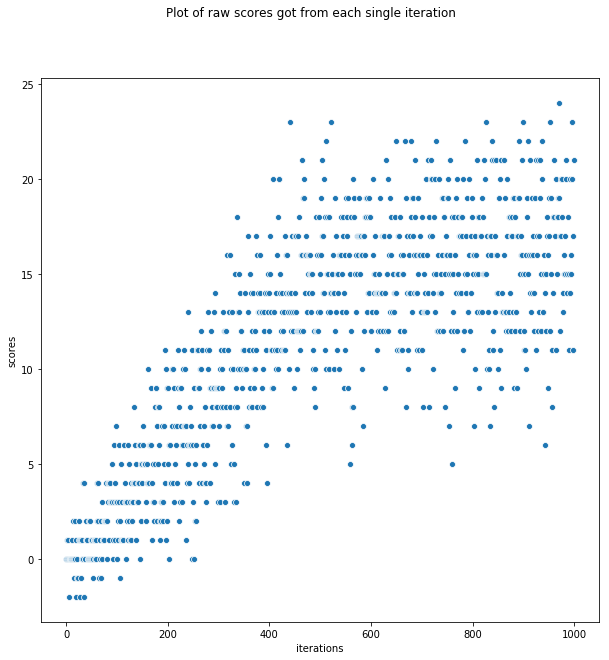

In [25]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(x='iterations', y='scores', data=data_basic_w, ax=ax)
plt.suptitle('Plot of raw scores got from each single iteration')

#### Dueling Weighted

In [24]:
# gives iteration with top scores for given experiment and avg scores (here counted for 30 consecutive samples)
get_best_avg_score(meta_dueling_w['scores'], 30)

(array([688, 687, 689]), array([ 16.93333333,  16.76666667,  16.73333333]))

In [21]:
# iteration when we for the first time reached avg score for 100 consecutive scores >=13
get_occurance(meta_dueling_w['scores'], n_samples=100, value=13)

435

Text(0.5,0.98,'Plot of raw scores got from each single iteration')

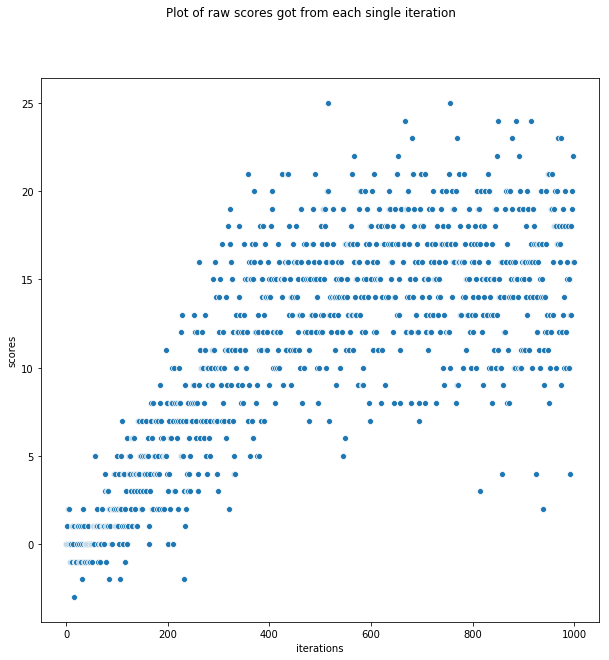

In [26]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(x='iterations', y='scores', data=data_dueling_w, ax=ax)
plt.suptitle('Plot of raw scores got from each single iteration')

## Next steps

### Experiments
 - analyze scores distributions (bootstrap results)
 - for each setup run 100 instaces of agents (to debias infuence of initialization)
 - search for optimal initial values of agent params
 - try different topologies of Q-deep network
 - setup visual environment, use convolution Q-network to predict action state values


### Architecture & Environment
 - optimize prioritized replay buffer with better data structure (something heap based with log(n) search complexity)
 - dockerize environment for experiments